In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chess-pieces-detection-images-dataset/Rook-resize/00000137_resized.jpg
/kaggle/input/chess-pieces-detection-images-dataset/Rook-resize/00000010_resized.jpg
/kaggle/input/chess-pieces-detection-images-dataset/Rook-resize/00000067_resized.jpg
/kaggle/input/chess-pieces-detection-images-dataset/Rook-resize/00000060_resized.jpg
/kaggle/input/chess-pieces-detection-images-dataset/Rook-resize/00000210_resized.jpg
/kaggle/input/chess-pieces-detection-images-dataset/Rook-resize/00000240_resized.jpg
/kaggle/input/chess-pieces-detection-images-dataset/Rook-resize/00000117_resized.jpg
/kaggle/input/chess-pieces-detection-images-dataset/Rook-resize/00000130_resized.jpg
/kaggle/input/chess-pieces-detection-images-dataset/Rook-resize/00000005_resized.jpg
/kaggle/input/chess-pieces-detection-images-dataset/Rook-resize/00000073_resized.jpg
/kaggle/input/chess-pieces-detection-images-dataset/Rook-resize/00000023_resized.jpg
/kaggle/input/chess-pieces-detection-images-dataset/Rook-resize/0

# ***Importing Libraries Required***

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from  keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Dropout,Dense,Flatten,MaxPooling2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.callbacks import EarlyStopping 

# ***Path of the Dataset***

In [3]:
path="../input/chess-pieces-detection-images-dataset"

# ***Spliting the Image Dataset into Training and Testing***

In [4]:
train_data=tf.keras.preprocessing.image_dataset_from_directory(path,validation_split=0.2,
                                                               image_size=(224,224),
                                                               batch_size=32,
                                                               subset="training",
                                                               seed=123)

Found 651 files belonging to 5 classes.
Using 521 files for training.


2022-08-10 11:29:00.294360: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 11:29:00.427699: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 11:29:00.428518: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 11:29:00.431563: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [5]:
test_data=tf.keras.preprocessing.image_dataset_from_directory(path,validation_split=0.2,
                                                               image_size=(224,224),
                                                               batch_size=32,
                                                               subset="validation",
                                                               seed=123)

Found 651 files belonging to 5 classes.
Using 130 files for validation.


# ***Building the Model***

In [6]:
class_names = ['Queen','Rook','bishop','knight','pawn']

In [7]:
inputs = tf.keras.Input(shape = (224,224,3))
preprocess = tf.keras.applications.mobilenet.preprocess_input(inputs)
upscale = tf.keras.layers.Lambda(lambda x : tf.image.resize_with_pad(x,
                                                                     224,
                                                                     224,
                                                                     method = tf.image.ResizeMethod.BILINEAR))(inputs)

In [8]:
mobilenet = MobileNet(include_top='True', weights='imagenet' ,input_tensor = (upscale),
                       input_shape = (224, 224, 3))

17235968/17225924 [==============================] - 0s 0us/step


In [9]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

# ***Building the Networks Using Mobilenet***

In [10]:
model = Sequential()
model.add(Rescaling(1./255 ,input_shape=(224,224,3)))
model.add(data_augmentation)
model.add(mobilenet)
model.add(Flatten())
model.add(Dense(128 , activation = 'relu'))
model.add(Dense(len(class_names) , activation = 'softmax'))
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),optimizer='adam' , metrics=['accuracy'])

In [11]:
model.summary()
mycallbacks = [EarlyStopping(monitor='val_loss',patience = 20 , restore_best_weights=True)]
hist = model.fit(train_data,validation_data= test_data, epochs=100, callbacks=mycallbacks)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 1000)              4253864   
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               128128    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 4,382,637
Trainable params: 4,360,749
Non-trainable params: 21,888
_______________________________________

2022-08-10 11:29:07.485804: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-08-10 11:29:09.960265: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


17/17 [==============================] - 15s 250ms/step - loss: 1.5913 - accuracy: 0.2975 - val_loss: 1.5982 - val_accuracy: 0.2538
Epoch 2/100
17/17 [==============================] - 3s 167ms/step - loss: 1.5279 - accuracy: 0.3973 - val_loss: 1.5853 - val_accuracy: 0.2538
Epoch 3/100
17/17 [==============================] - 3s 168ms/step - loss: 1.4302 - accuracy: 0.6200 - val_loss: 1.6097 - val_accuracy: 0.1692
Epoch 4/100
17/17 [==============================] - 3s 177ms/step - loss: 1.3094 - accuracy: 0.7063 - val_loss: 1.5467 - val_accuracy: 0.2538
Epoch 5/100
17/17 [==============================] - 3s 169ms/step - loss: 1.2315 - accuracy: 0.6545 - val_loss: 1.4814 - val_accuracy: 0.3231
Epoch 6/100
17/17 [==============================] - 3s 168ms/step - loss: 1.1727 - accuracy: 0.6488 - val_loss: 1.7162 - val_accuracy: 0.2231
Epoch 7/100
17/17 [==============================] - 3s 171ms/step - loss: 1.0980 - accuracy: 0.6564 - val_loss: 1.6594 - val_accuracy: 0.2231
Epoch 8/10

# ***Polting the model history***

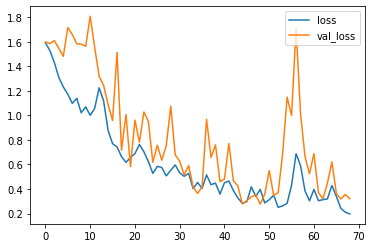

In [12]:
plt.figure()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss','val_loss'],loc='upper right')
plt.show()

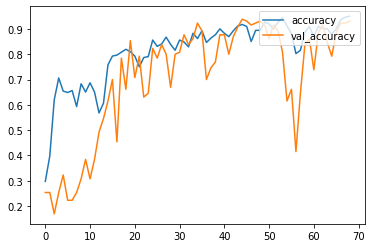

In [13]:
plt.figure()
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'],loc='upper right')
plt.show()